In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
plt.rcParams['figure.dpi'] = 150
import seaborn as sns
import scipy.stats as st
import statsmodels.api as sm
from functools import reduce

import glob, os, yaml, subprocess, itertools, sparse, sys
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GridSearchCV, cross_val_score, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

# eigenvec_df = pd.read_csv("../data/eigenvec_original_10PC.csv", index_col=[0])
# eigenvec_df = pd.read_csv("../data/eigenvec_1000PC.csv", index_col=[0])
# eigenvec_df = pd.read_csv("data/eigenvec_100PC.csv", index_col=[0])
# who_variants = pd.read_csv("../data/who_confidence_2021.csv")
drug_gene_mapping = pd.read_csv("../data/drug_gene_mapping.csv")
analysis_dir = '/n/data1/hms/dbmi/farhat/Sanjana/who-mutation-catalogue'
drugs_lst = os.listdir(analysis_dir)

lineages = pd.read_csv("../data/combined_lineages_samples.csv", low_memory=False)#.query("sample_id in @eigenvec_df.index")
print(lineages.shape)
import collections, warnings
warnings.filterwarnings("ignore")

# utils files are in a separate folder
sys.path.append(os.path.join(os.path.dirname(os.getcwd()), "utils"))
from data_utils import *
from stats_utils import *

solo_results = pd.read_csv("../results/SOLO_Final_Aug2023.csv", header=[1])
cc_df = pd.read_csv("../data/drug_CC.csv")

coll2014 = pd.read_csv("../data/coll2014_SNP_scheme.tsv", sep="\t")
coll2014["#lineage"] = coll2014["#lineage"].str.replace("lineage", "")
coll2014.rename(columns={"#lineage": "Lineage"}, inplace=True)

drug_abbr_dict = {"Delamanid": "DLM",
                  "Bedaquiline": "BDQ",
                  "Clofazimine": "CFZ",
                  "Ethionamide": "ETH",
                  "Linezolid": "LZD",
                  "Moxifloxacin": "MXF",
                  "Capreomycin": "CAP",
                  "Amikacin": "AMI",
                  "Pretomanid": "PTM",
                  "Pyrazinamide": "PZA",
                  "Kanamycin": "KAN",
                  "Levofloxacin": "LEV",
                  "Streptomycin": "STM",
                  "Ethambutol": "EMB",
                  "Isoniazid": "INH",
                  "Rifampicin": "RIF"
                 }

# hard coded paths to preserve the model hierarchy
binary_analyses_lst = [
                        "tiers=1/phenos=WHO",
                        "tiers=1+2/phenos=WHO",
                        "tiers=1/phenos=ALL",
                        "tiers=1+2/phenos=ALL"
                      ]

model_names = ["Tier 1,\nWHO Phenos", "Tiers 1+2,\nWHO Phenos", "Tier 1,\nALL Phenos", "Tiers 1+2,\nALL Phenos"]
path_name_dict = dict(zip(binary_analyses_lst, model_names))

(49113, 7)


# Plot Metrics for all Drugs with Exact Confidence Intervals (Regression ONLY, no SOLO)

In [28]:
metrics_names_dict = {'Sens': 'Sensitivity',
                       'Spec': 'Specificity',
                       'F1': 'F1 Score',
                       'PPV': 'PPV',
                       'NPV': 'NPV',
                       'Accuracy': 'Accuracy',
                      'BalancedAcc': 'Balanced Accuracy'
                      }

def regression_binary_metrics_all_drugs(drugs_lst, metrics_lst, saveName=None):

    fig, ax = plt.subplots(1, 1, figsize=(12, 4))

    plot_df = []
    metric_legend_dict = {}
    metric_colors = sns.color_palette("Set2")
    
    for drug in drugs_lst:
    
        # if drug == 'Pretomanid':
        #     phenos_name = 'WHO'
        # else:
        #     phenos_name = "ALL"

        phenos_name = "ALL"

        if drug != "Pretomanid":
            stats = pd.read_csv(os.path.join(analysis_dir, drug, f"BINARY/tiers=1/phenos={phenos_name}/model_stats_AF75.csv"), index_col=[0])
            stats['Drug'] = drug
            plot_df.append(pd.DataFrame(stats.loc["Catalog"]).T.rename(index={'Catalog': 'Regression'}))
        
    plot_df = pd.concat(plot_df).dropna(axis=1).reset_index(drop=True).set_index("Drug")

    # sort decreasing by the first metric
    drugs_lst = plot_df.sort_values(metrics_lst[0], ascending=False).index.unique()
    
    # Bar width and positions
    bar_width = 0.4
    bar_positions = np.arange(len(drugs_lst))
    
    errwidth = 0.04
    errlinewidth = 0.5
    
    for i, drug in enumerate(drugs_lst):

        for j, metric in enumerate(metrics_lst):
                
            test = plot_df.loc[drug, metric] * 100
            lower = plot_df.loc[drug, f"{metric}_lb"] * 100
            upper = plot_df.loc[drug, f"{metric}_ub"] * 100
            
            # Plot the test value as a bar
            patch = ax.bar(i + j * bar_width, test, bar_width, color=sns.color_palette("Set2").as_hex()[j], linewidth=0.5, edgecolor='black', label=metric)                
            ax.bar_label(patch, label_type='center', fmt='%.1f', fontsize=8)
            
            # Plot the confidence interval as a vertical line
            ax.vlines(i + j * bar_width, lower, upper, color='black', linewidth=errlinewidth)
    
            # plot horizontal lines to make the error bars look nicer
            ax.hlines(lower, i + j * bar_width  - errwidth, i + j * bar_width + errwidth, color='black', linewidth=errlinewidth)
            ax.hlines(upper, i + j * bar_width - errwidth, i + j * bar_width + errwidth, color='black', linewidth=errlinewidth)

            # Store metric information in the legend dictionary
            if metrics_names_dict[metric] not in metric_legend_dict:
                metric_legend_dict[metrics_names_dict[metric]] = (metric_colors[i], patch)

    # ax.set_title(metric, fontsize=10)
    # remove x-axis ticks and labels
    # ax.set_xticks(bar_positions)

    # dodge ticks so that they are in the middle of each group of bars
    ax.set_xticks([pos + bar_width / len(metrics_lst) for pos in bar_positions])
    # ax.set_xticklabels([drug_abbr_dict[drug] for drug in drugs_lst])
    ax.set_xticklabels(drugs_lst, fontsize=7)
    ax.set_yticklabels(np.array(ax.get_yticks()).astype(int), fontsize=9)
    
    # Show the plot
    handles, labels = zip(*[(metric_legend_dict[metric][1], metric) for metric in metric_legend_dict])
    ax.legend(handles, labels, bbox_to_anchor=(0.55, -0.15), loc="lower right", ncol=len(metrics_lst), fontsize=7)
    sns.despine()
    plt.tight_layout()
    plt.ylim(0, 100)

    # Set the x-axis limits to reduce the space on both ends
    ax.set_xlim(-0.4, len(drugs_lst) - 0.3)
    
    sns.despine()

    if saveName is None:
        plt.show()
    else:
        plt.savefig(saveName, dpi=300, bbox_inches="tight")

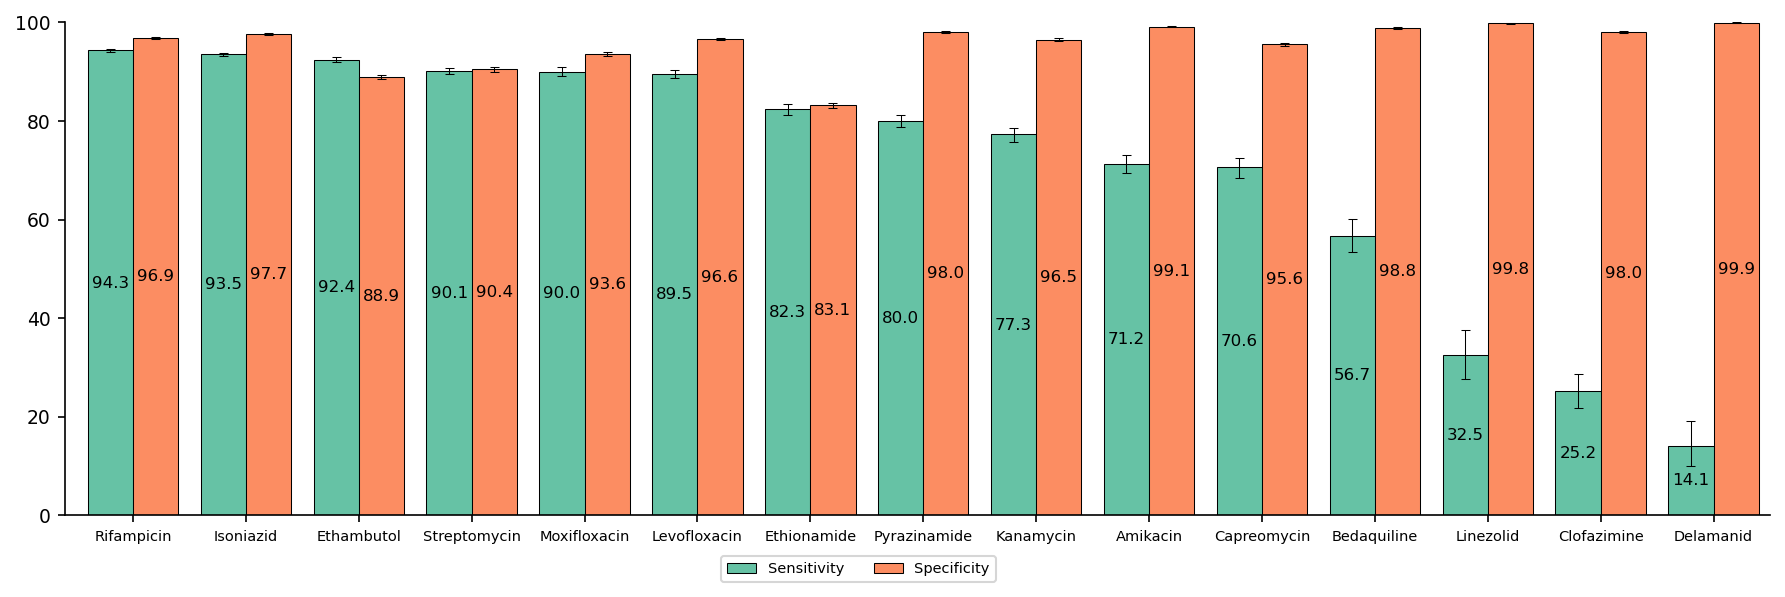

In [29]:
regression_binary_metrics_all_drugs(drugs_lst, ["Sens", "Spec"], saveName="TBScience_sens_spec.png")

# MIC Model Analysis

In [6]:
BDQ_WHO_analysis = pd.read_csv(os.path.join(analysis_dir, "Bedaquiline", "BINARY", "tiers=1/phenos=WHO", "dropAF_noSyn_unpooled", "model_analysis.csv"))
BDQ_WHO_LRT = pd.read_csv(os.path.join(analysis_dir, "Bedaquiline", "BINARY", "tiers=1/phenos=WHO", "dropAF_noSyn_unpooled", "LRT_results.csv"))

BDQ_ALL_analysis = pd.read_csv(os.path.join(analysis_dir, "Bedaquiline", "BINARY", "tiers=1/phenos=ALL", "dropAF_noSyn_unpooled", "model_analysis.csv"))
BDQ_ALL_LRT = pd.read_csv(os.path.join(analysis_dir, "Bedaquiline", "BINARY", "tiers=1/phenos=ALL", "dropAF_noSyn_unpooled", "LRT_results.csv"))

BDQ_MIC_analysis = pd.read_csv(os.path.join(analysis_dir, "Bedaquiline", "MIC", "tiers=1", "dropAF_noSyn_unpooled", "model_analysis.csv"))
# BDQ_genos = pd.read_csv(os.path.join(analysis_dir, "Bedaquiline", "genos_1.csv.gz"), compression="gzip")
# BDQ_genos["mutation"] = BDQ_genos["resolved_symbol"] + "_" + BDQ_genos["variant_category"]

# del BDQ_genos["resolved_symbol"]
# del BDQ_genos["variant_category"]

In [77]:
BDQ_MICs = pd.read_csv(os.path.join(analysis_dir, "Bedaquiline", "phenos_mic.csv"))
print(BDQ_MICs.shape)
BDQ_MICs = process_multiple_MICs_different_media(BDQ_MICs)
print(BDQ_MICs.shape)

# add variable denoting if mmpS5_c.-74G>T is present in a sample or not
samples_with_variant = BDQ_genos.query("mutation=='mmpS5_c.-74G>T' & variant_binary_status==1").sample_id.values
BDQ_MICs.loc[BDQ_MICs["sample_id"].isin(samples_with_variant), "mutation"] = 1
BDQ_MICs["mutation"] = BDQ_MICs["mutation"].fillna(0).astype(int)

(12869, 7)
(12646, 7)


In [97]:
BDQ_MICs.shape, BDQ_MICs.sample_id.nunique()

((12646, 8), 12646)

In [98]:
BDQ_MICs.query("mutation==1").sample_id.nunique()

113

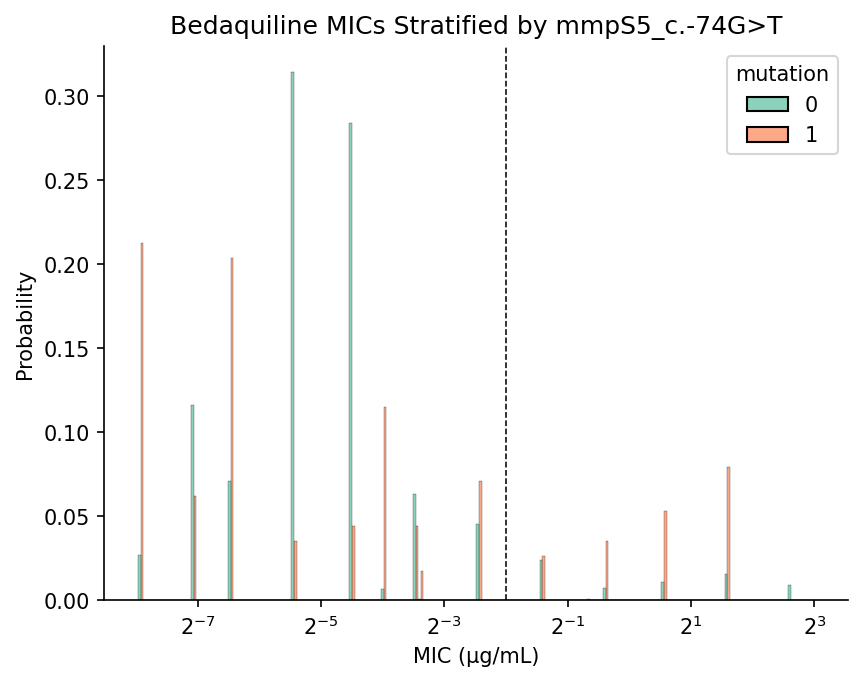

In [94]:
sns.histplot(data=BDQ_MICs.sort_values("mutation", ascending=True),
             x="mic_value",
             hue="mutation", 
             hue_order=[0, 1],
             log_scale=2,
             stat="probability",
             common_norm=False,
             multiple="dodge",
             palette="Set2",
             legend=True
            )

plt.axvline(0.25, linestyle='--', linewidth=0.75, color="black")
plt.title("Bedaquiline MICs Stratified by mmpS5_c.-74G>T")
plt.xlabel("MIC (µg/mL)")

sns.despine()
plt.savefig("BDQ_mmpS5_variant_MIC.png", dpi=300, bbox_inches="tight")

In [86]:
search_lst = BDQ_MICs.query("mic_value > 0.25 & mutation==1").sample_id.values
print(len(search_lst))

# what other mutations do they have?
muts_lst = BDQ_genos.query("sample_id in @search_lst & variant_binary_status == 1 & mutation != 'mmpS5_c.-74G>T'").mutation.unique()
BDQ_genos.query("sample_id in @search_lst & variant_binary_status == 1 & mutation != 'mmpS5_c.-74G>T'").mutation.value_counts()

22


mutation
mmpL5_p.Ile948Val    22
mmpL5_p.Thr794Ile    22
mmpL5_p.Asp767Asn    22
atpE_p.Ile66Met       2
Rv0678_p.Glu49fs      2
Rv0678_p.Asp47fs      2
Rv0678_p.Gln115*      1
Rv0678_p.Cys46Arg     1
Name: count, dtype: int64

In [ ]:
Eight samples contain atpE_p.Ile66Met (2), Rv0678_p.Glu49fs (2), Rv0678_p.Asp47fs (2), Rv0678_p.Gln115* (1), and Rv0678_p.Cys46Arg (1), which are graded as strongly or interim-associated with Bedaquiline resistance in SOLO V2. 

In [90]:
BDQ_genos.query("sample_id in @search_lst & variant_binary_status == 1 & ~mutation.str.contains('mmp')").sample_id.nunique()

8

In [89]:
BDQ_genos.query("sample_id in @search_lst & variant_binary_status == 1 & ~mutation.str.contains('mmp')")

,sample_id,predicted_effect,variant_allele_frequency,variant_binary_status,position,mutation
3370,822946,missense_variant,1.00,1.0,1461242,atpE_p.Ile66Met
22852,823148,missense_variant,1.00,1.0,1461242,atpE_p.Ile66Met
4208537,822943,frameshift,0.96,1.0,779130,Rv0678_p.Glu49fs
4213193,823349,frameshift,0.96,1.0,779130,Rv0678_p.Glu49fs
4520902,823314,stop_gained,1.00,1.0,779332,Rv0678_p.Gln115*
9268966,823466,missense_variant,1.00,1.0,779125,Rv0678_p.Cys46Arg
9502540,823455,frameshift,0.99,1.0,779129;779126;779127;779121;779128;779125;779122,Rv0678_p.Asp47fs
9506660,823065,frameshift,0.99,1.0,779129;779126;779127;779121;779128;779125;779122,Rv0678_p.Asp47fs


In [91]:
solo_results.query("drug=='Bedaquiline' & variant in @muts_lst & ~variant.str.contains('mmp')")[['variant', 'effect', 'Additional grading criteria applied', 'FINAL CONFIDENCE GRADING', 'Comment', 'CHANGES vs ver1']]

,variant,effect,Additional grading criteria applied,FINAL CONFIDENCE GRADING,Comment,CHANGES vs ver1
2205,atpE_p.Ile66Met,missense_variant,Evidence from ALL dataset only,2) Assoc w R - Interim,Includes data from one site that only submitte...,New AwRI
3226,Rv0678_p.Asp47fs,frameshift,NaN,1) Assoc w R,Can only confer resistance if genetically link...,New AwR
3234,Rv0678_p.Cys46Arg,missense_variant,Potentially inflated PPV,2) Assoc w R - Interim,Includes data from one site that only submitte...,UP from Uncertain to AwRI
3240,Rv0678_p.Gln115*,stop_gained,Indel frameshift or premature stop codon (LoF),2) Assoc w R - Interim,Can only confer resistance if genetically link...,UP from Uncertain to AwRI
3262,Rv0678_p.Glu49fs,frameshift,NaN,1) Assoc w R,Can only confer resistance if genetically link...,UP from Uncertain to AwR


In [93]:
solo_results.query("drug=='Bedaquiline' & variant=='mmpS5_c.-74G>T'")

,drug,gene,mutation,variant,tier,effect,genomic position,algorithm_pass,Present_SOLO_SR,Present_SOLO_R,...,Additional grading criteria applied,FINAL CONFIDENCE GRADING,Comment,CHANGES vs ver1,"Relaxed thresholds simulation (BDQ_Rv0678, CFZ_Rv0678, INH_katG, DLM_ddn/fbiA/fbiB/fbiC/fgd1/Rv2983)",Silent mutation,Listed in abridged tables,Additional grading,Footnote,CHANGES vs ver1.1
2753,Bedaquiline,mmpS5,c.-74G>T,mmpS5_c.-74G>T,1,upstream_gene_variant,778979.0,0.0,0.0,0.0,...,Literature evidence (PMID 28031270; 34503982),4) Not assoc w R - Interim,NaN,UP from Uncertain to NotAwRI,NaN,NaN,yes,Lit. (PMID 28031270; 34503982),NaN,4


In [35]:
BDQ_WHO_analysis.query("mutation=='mmpS5_c.-74G>T'")[['mutation', 'Odds_Ratio', 'BH_pval', 'PPV_LB', 'PPV', 'PPV_UB', 'Mut_R',
       'Mut_S', 'NoMut_S', 'NoMut_R']].merge(BDQ_WHO_LRT.query("mutation=='mmpS5_c.-74G>T'")[['mutation', 'LRT_pval']])

,mutation,Odds_Ratio,BH_pval,PPV_LB,PPV,PPV_UB,Mut_R,Mut_S,NoMut_S,NoMut_R,LRT_pval
0,mmpS5_c.-74G>T,1.40935,0.0,0.769425,0.914286,0.981962,32.0,3.0,1245.0,732.0,1.462151e-14


In [30]:
cc_df.query("Drug=='Bedaquiline'")

,Medium,Value,Drug
18,UKMYC5,0.25,Bedaquiline
19,UKMYC6,0.25,Bedaquiline
32,7H11,0.25,Bedaquiline
51,MGIT,1.00,Bedaquiline


In [44]:
32/(32+732), 3/(3+1245)

(0.041884816753926704, 0.002403846153846154)

In [45]:
0.041884816753926704/0.002403846153846154

17.42408376963351

In [34]:
32/35

0.9142857142857143

In [36]:
BDQ_ALL_analysis.query("mutation=='mmpS5_c.-74G>T'")[['mutation', 'Odds_Ratio', 'BH_pval', 'PPV_LB', 'PPV', 'PPV_UB', 'Mut_R',
       'Mut_S', 'NoMut_S', 'NoMut_R']].merge(BDQ_ALL_LRT.query("mutation=='mmpS5_c.-74G>T'")[['mutation', 'LRT_pval']])

,mutation,Odds_Ratio,BH_pval,PPV_LB,PPV,PPV_UB,Mut_R,Mut_S,NoMut_S,NoMut_R,LRT_pval
0,mmpS5_c.-74G>T,1.219286,0.0,0.188448,0.264463,0.352361,32.0,89.0,12892.0,848.0,1.551669e-39


In [46]:
32/(32+848), 89/(89+12892)

(0.03636363636363636, 0.006856174408751252)

In [47]:
0.03636363636363636/0.006856174408751252

5.303779366700715

In [37]:
32/121

0.2644628099173554

In [3]:
BDQ_MIC_analysis.query("mutation=='mmpS5_c.-74G>T'")

,mutation,coef,pval,neutral_pval,BH_pval,Bonferroni_pval,BH_neutral_pval,Bonferroni_neutral_pval,confidence
379,mmpS5_c.-74G>T,-0.003734,0.424,0.167,0.4872,1.0,1.0,1.0,3) Uncertain significance


In [42]:
solo_results.query("variant=='mmpS5_c.-74G>T'")

,drug,gene,mutation,variant,tier,effect,genomic position,algorithm_pass,Present_SOLO_SR,Present_SOLO_R,...,Additional grading criteria applied,FINAL CONFIDENCE GRADING,Comment,CHANGES vs ver1,"Relaxed thresholds simulation (BDQ_Rv0678, CFZ_Rv0678, INH_katG, DLM_ddn/fbiA/fbiB/fbiC/fgd1/Rv2983)",Silent mutation,Listed in abridged tables,Additional grading,Footnote,CHANGES vs ver1.1
2753,Bedaquiline,mmpS5,c.-74G>T,mmpS5_c.-74G>T,1,upstream_gene_variant,778979.0,0.0,0.0,0.0,...,Literature evidence (PMID 28031270; 34503982),4) Not assoc w R - Interim,NaN,UP from Uncertain to NotAwRI,NaN,NaN,yes,Lit. (PMID 28031270; 34503982),NaN,4
7451,Clofazimine,mmpS5,c.-74G>T,mmpS5_c.-74G>T,1,upstream_gene_variant,778979.0,1.0,64.0,1.0,...,NaN,3) Uncertain significance,NaN,No change,NaN,NaN,no,NaN,NaN,1


In [ ]:
For example, the distribution of mmpS5_c.-74G>T (Rv0678_c.-11C>A) between BDQ-R and BDQ-S isolates is very different between the WHO and ALL datasets. In the WHO dataset, it is graded as Assoc w R, but Uncertain in the ALL dataset because of its low positive predictive value (PPV) lower bound (0.77 vs. 0.19). In the model regressing BDQ MICs on genotypes, this variant has a small but insignificant negative association with BDQ MIC (coefficient = -0.004). 

# Plot Sensitivity, Specificity, and AUC for Each Drug with Bootstrapped Confidence Intervals

In [2]:
def single_drug_bar_chart(drug, variable_lst, include_het=False, binary_analyses_lst=binary_analyses_lst, bootstrap=False, errorbar=None, palette="muted", sigfig=1, saveName=None):
    
    concat_models = []
    
    if include_het:
        model_prefix = "_HET"
    else:
        model_prefix = ""
        
    if bootstrap:
        model_prefix += "_bootstrap"
        
    if drug == "Pretomanid":
        binary_analyses_lst = [path for path in binary_analyses_lst if "ALL" in path and "1+2" not in path]
    
    hue_order = ["Tier 1,\nWHO Phenos", "Tier 1,\nALL Phenos", "Tiers 1+2,\nWHO Phenos", "Tiers 1+2,\nALL Phenos"]
    #hue_order = ["Tier 1,\nWHO Phenos", "Tier 1,\nALL Phenos", "Tiers 1+2,\nWHO Phenos", "Tiers 1+2,\nALL Phenos", "V1 Catalogue,\nWHO Phenos", "V1 Catalogue,\nALL Phenos"]
        
    for path in binary_analyses_lst:
        
        if os.path.isfile(os.path.join(analysis_dir, drug, "BINARY", path, f"model_stats_CV{model_prefix}.csv")):
            df = pd.read_csv(os.path.join(analysis_dir, drug, "BINARY", path, f"model_stats_CV{model_prefix}.csv"))
        else:
            df = pd.read_csv(os.path.join(analysis_dir, drug, "BINARY", path.replace("tiers=1+2", "tiers=1"), f"model_stats_CV{model_prefix}.csv"))
        
        df["Model"] = path_name_dict[path]
        concat_models.append(df)

    df_plot = pd.concat(concat_models, axis=0)
    
        
    # if there is no HET in the model prefix, use threshold of 0.75. If HET, use threshold of 0.25
    if include_het:
        AF_thresh = 0.25
        title_str = "+HET"
    else:
        AF_thresh = 0.75
        title_str = "-HET"
        
    #catalog_WHO, catalog_ALL = classify_using_V1_catalog(drug, AF_thresh, num_bootstrap=1000)
    catalog_WHO = None
    catalog_ALL = None
    df_plot = pd.concat([df_plot, catalog_WHO, catalog_ALL], axis=0)

    df_plot = df_plot.melt(id_vars=["Model"])
    df_plot["variable"] = df_plot["variable"].replace("Sens", "Sensitivity").replace("Spec", "Specificity").replace("Balanced_Acc", "Balanced Accuracy")
    df_plot = df_plot.query("variable in @variable_lst")#.query("CV > 0")
    df_plot["value"] *= 100
    
    # if catalog_WHO is not None:
    #     plot_width = 8
    #     hue_order = ["Tier 1,\nWHO Phenos", "Tier 1,\nALL Phenos", "Tiers 1+2,\nWHO Phenos", "Tiers 1+2,\nALL Phenos", "V1 Catalogue,\nWHO Phenos", "V1 Catalogue,\nALL Phenos"]
    #     # x_order = ["Tier 1,\nWHO Phenos", "Tiers 1+2,\nWHO Phenos", "V1 Catalogue,\nWHO Phenos", "Tier 1,\nALL Phenos", "Tiers 1+2,\nALL Phenos", "V1 Catalogue,\nALL Phenos"]
    # else:
    #     plot_width = 6
    #     hue_order = ["Tier 1,\nWHO Phenos", "Tier 1,\nALL Phenos", "Tiers 1+2,\nWHO Phenos", "Tiers 1+2,\nALL Phenos"]
    #     # x_order=["Tier 1,\nWHO Phenos", "Tiers 1+2,\nWHO Phenos", "Tier 1,\nALL Phenos", "Tiers 1+2,\nALL Phenos"]
    plot_width = 2 * len(df_plot["variable"].unique())       
    palette = list(sns.color_palette("Paired").as_hex())
    
    # first pair is blue, second is orange, third is green, fourth is purple
    palette = palette[:2] + palette[6:8] + palette[2:4] + palette[8:10]
    
    fig, ax = plt.subplots(figsize=(plot_width, 4))
    sns.barplot(data=df_plot,
                x="variable",
                y="value",
                hue="Model",
                hue_order=hue_order,
                order=variable_lst,
                errorbar=errorbar,
                errwidth=0.75,
                capsize=0.05,
                palette=palette,
                ax=ax
                )
    
    # bar_scale = 0.8
    # for patch in ax.patches:
    #     current_width = patch.get_width()
    #     patch.set_width(current_width * bar_scale)
        
    label_loc = 'center'
    
    if sigfig == 1:
        font_size = '8'
    else:
        font_size = '10'

    for cont in ax.containers:
        labels = [np.round(val, sigfig) if val > 0 else "" for val in cont.datavalues]    
        ax.bar_label(cont, labels=labels, label_type=label_loc, fontsize=font_size)

    plt.ylim(0, 100)
    plt.title(f"{drug} Models\n")
    plt.xlabel("")
    plt.ylabel("")
    sns.move_legend(ax, fontsize=8, title='', loc='upper right', #bbox_to_anchor=(1.12, 0.6)
                    ncol=len(df_plot["Model"].unique()) / 2, bbox_to_anchor=(0.7, -0.1)
                   )

    sns.despine()
    plt.tight_layout()
    
    if saveName is None:
        plt.show()
    else:
        if not os.path.isdir(os.path.dirname(saveName)):
            os.makedirs(os.path.dirname(saveName))
        plt.savefig(saveName, dpi=300)
        
    return df_plot


def significance_test_HET_results(DROP_results, HET_results, variable_lst):
                    
    for var in variable_lst:
        
        x_var = DROP_results.query("CV > 0")[var].values
        y_var = HET_results.query("CV > 0")[var].values
        
        if st.normaltest(x_var) and st.normaltest(y_var):
            test_type = "parametric"
        else:
            test_type = "non"
        
        # alternative hypothesis is that the model with HETs is better
        if test_type == "parametric":
            _, pval = st.ttest_ind(x_var, y_var, alternative='two-sided', equal_var=False)
        else:
            _, pval = st.mannwhitneyu(x_var, y_var, alternative='two-sided')
        
        if pval < 0.05:
            
            mean_diff = np.mean(y_var) - np.mean(x_var)
            
            if test_type == "parametric":
                _, pval = st.ttest_ind(x_var, y_var, alternative='less', equal_var=False)
            else:
                _, pval = st.mannwhitneyu(x_var, y_var, alternative='less')
            
            if pval < 0.05:
                print(f"{var}: HET +{np.round(mean_diff, 2)}")
            else:
                if test_type == "parametric":
                    _, pval = st.ttest_ind(x_var, y_var, alternative='greater', equal_var=False)
                else:
                    _, pval = st.mannwhitneyu(x_var, y_var, alternative='greater')

                if pval < 0.05:
                    print(f"{var}: HET -{np.round(-mean_diff, 4)}")

In [3]:
# Levofloxacin: sens = 84.6, spec = 97

In [4]:
# very bad, not very informative results. Just compare mutations for PTM
# drug = "Pretomanid"
# # 695/5, 
# # variable_lst = ["AUC", "Sens", "Spec"]#, "Balanced_Acc"]

# plot_everything_check_significance(drug)

In [5]:
# drug = "Pretomanid"
# PTM_results, PTM_het_results = plot_everything_check_significance(drug, variable_lst=["AUC"])#saveName_DROP="results/TBScience/BDQ_no_HETs.png", saveName_HET="results/TBScience/BDQ_with_HETs.png")

In [114]:
drug = "Bedaquiline"
path = 'tiers=1+2/phenos=ALL'
variable_lst = ["Sens", "Spec", "AUC", "Balanced_Acc"]
results = pd.read_csv(os.path.join(analysis_dir, drug, "BINARY", path, "model_stats_CV_bootstrap.csv"))
HET_results = pd.read_csv(os.path.join(analysis_dir, drug, "BINARY", path, "model_stats_CV_HET_bootstrap.csv"))

significance_test_HET_results(results, HET_results, variable_lst)

Sens: HET +0.02
Spec: HET -0.0022
AUC: HET +0.01
Balanced_Acc: HET +0.01


In [115]:
drug = "Levofloxacin"
path = 'tiers=1+2/phenos=ALL'
variable_lst = ["Sens", "Spec", "AUC", "Balanced_Acc"]
results = pd.read_csv(os.path.join(analysis_dir, drug, "BINARY", path, "model_stats_CV_bootstrap.csv"))
HET_results = pd.read_csv(os.path.join(analysis_dir, drug, "BINARY", path, "model_stats_CV_HET_bootstrap.csv"))

significance_test_HET_results(results, HET_results, variable_lst)

Sens: HET +0.01
Spec: HET -0.0045
AUC: HET +0.0
Balanced_Acc: HET +0.0


In [69]:
np.percentile(BDQ_HET_results["Accuracy"], q=[2.5, 97.5])

array([0.91839479, 0.92879892])

In [66]:
np.mean(BDQ_results["Accuracy"])

0.9250433242417784

In [78]:
st.normaltest(BDQ_results["Accuracy"])[1], st.normaltest(BDQ_HET_results["Accuracy"])[1]

(3.8831529356799404e-05, 1.0534967777069153e-20)

(array([ 31., 108., 290., 320., 182.,  55.,   9.,   2.,   2.,   2.]),
 array([0.91634227, 0.91854342, 0.92074457, 0.92294571, 0.92514686,
        0.92734801, 0.92954915, 0.9317503 , 0.93395145, 0.93615259,
        0.93835374]),
 <BarContainer object of 10 artists>)

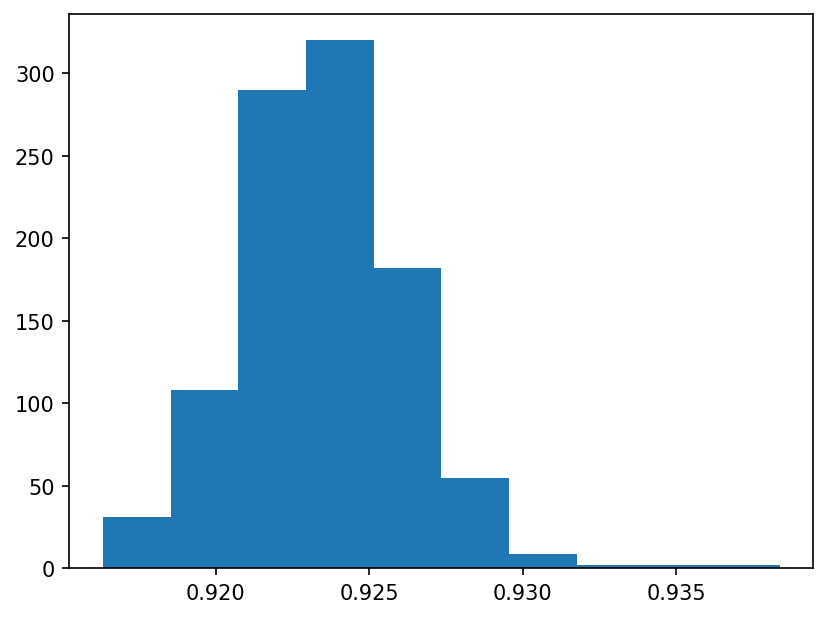

In [79]:
plt.hist(BDQ_HET_results["Accuracy"])

In [68]:
np.percentile(BDQ_results["Accuracy"], q=[2.5, 97.5])

array([0.92056108, 0.92936377])

In [52]:
os.path.join(analysis_dir, drug, "BINARY", path)

'/n/data1/hms/dbmi/farhat/Sanjana/who-mutation-catalogue/Bedaquiline/BINARY/tiers=1+2/phenos=ALL'

In [51]:
BDQ_results

,AUC,Sens,Spec,Precision,Accuracy,Balanced_Acc,CV
0,0.845175,0.656608,0.944205,0.464996,0.924426,0.800407,0
1,0.840464,0.631463,0.945729,0.447389,0.925284,0.788596,1
2,0.843917,0.647716,0.943486,0.465015,0.922637,0.795601,2
3,0.840863,0.646377,0.946978,0.493727,0.924712,0.796677,3
4,0.843228,0.646444,0.944688,0.461883,0.924283,0.795566,4
...,...,...,...,...,...,...,...
996,0.839753,0.654255,0.945446,0.463801,0.925857,0.799851,996
997,0.844460,0.665635,0.943863,0.469091,0.924569,0.804749,997
998,0.851004,0.654088,0.943928,0.460857,0.924139,0.799008,998
999,0.841445,0.650054,0.946897,0.464037,0.927288,0.798475,999


In [8]:
# drug = "Moxifloxacin"
# MXF_results, MXF_HET_results = plot_everything_check_significance(drug, variable_lst=["Sensitivity", "Specificity", "AUC", "Balanced Accuracy"])#saveName_DROP="results/TBScience/BDQ_no_HETs.png", saveName_HET="results/TBScience/BDQ_with_HETs.png")

# Plot Statistics for a Single Model for all Drugs

In [46]:
def plot_single_model_all_drugs(paths_lst, 
                                hue_variable,
                                variable_lst, 
                                x_order=["Levofloxacin", "Moxifloxacin", "Bedaquiline", "Clofazimine", "Linezolid", "Delamanid", "Pretomanid"],
                                bootstrap=False, errorbar=None, include_het=False, palette="muted", sigfig=1, saveName=None
                               ):
        
    if include_het:
        model_prefix = "_HET"
        title_str = " +HET"
    else:
        model_prefix = ""
        title_str = " -HET"
            
    if bootstrap:
        model_prefix += "_bootstrap"

    concat_models = []
    for drug in x_order:
        
        for path in paths_lst:
            
            full_path = os.path.join(analysis_dir, drug, "BINARY", path, f"model_stats_CV{model_prefix}.csv")
            tier1_path = os.path.join(analysis_dir, drug, "BINARY", path.replace("1+2", "1"), f"model_stats_CV{model_prefix}.csv")

            if os.path.isfile(full_path):
                df = pd.read_csv(full_path)
                print(f"Tiers 1+2 for {drug}")
            elif os.path.isfile(tier1_path):
                df = pd.read_csv(tier1_path)
                print(f"Tier 1 for {drug}")
            else:
                df = pd.DataFrame({"AUC": 0, "Sens": 0, "Spec": 0, "Precision": 0, "Accuracy": 0, "Balanced_Acc": 0}, index=[0])
                print(f"No results for {drug}")
            
            df["Drug"] = drug
            df["F1"] = 2 / ((1 / df["Precision"]) + (1 / df["Sens"]))
            
            if len(paths_lst) > 1:
                df["Model"] = path_name_dict[path]

            concat_models.append(df)
            
    df_plot = pd.concat(concat_models, axis=0)
    
    if len(paths_lst) > 1:
        df_plot = df_plot.melt(id_vars=["Drug", "Model"])
    else:
        df_plot = df_plot.melt(id_vars=["Drug"])

    df_plot["variable"] = df_plot["variable"].replace("Sens", "Sensitivity").replace("Spec", "Specificity").replace("Balanced_Acc", "Balanced Accuracy")
    df_plot = df_plot.query("variable in @variable_lst")#.query("CV > 0")
    df_plot["value"] *= 100
    
    x_order = [drug for drug in x_order if drug in df_plot["Drug"].values]
    plot_width = 1.5 * len(df_plot["Drug"].unique())

    fig, ax = plt.subplots(figsize=(plot_width, 4.5))
    sns.barplot(data=df_plot,
                x="Drug",
                y="value",
                hue=hue_variable,
                edgecolor="black",
                linewidth=0.5,
                hue_order=variable_lst,
                order=x_order,
                errorbar=errorbar,
                errwidth=0.75,
                capsize=0,
                palette=palette,
                ax=ax
                )

    for i, line in enumerate(ax.get_lines()):
        line.set_color("black")
    
    # label_loc = 'center'

    # for cont in ax.containers:
    #     if sigfig == 0:
    #         labels = [int(np.rint(val)) if val > 0 else "" for val in cont.datavalues] 
    #         font_size = "9"
    #     else:
    #         labels = [np.round(val, sigfig) if val > 0 else "" for val in cont.datavalues]    
    #         font_size = "7"
            
    #     ax.bar_label(cont, labels=labels, label_type=label_loc, fontsize=font_size)

    plt.ylim(0, 101)
                                   
    # # Duplicate the y-axis
    # ax2 = ax.twinx()
    
    # # Set the limits of the duplicated y-axis to be the same as the original y-axis
    # ax2.set_ylim(ax.get_ylim())
    
    # # Remove the ticks and labels from the duplicated y-axis
    # ax2.set_yticks(ticks=ax.get_yticks(), labels=ax.get_yticklabels())
    
    # plt.title(f"{path}, {title_str}\n")
    plt.xlabel("")
    plt.ylabel("")
    # plt.legend(loc="upper right", fontsize=8)

    sns.move_legend(ax, fontsize=8, title='', loc='upper right', #bbox_to_anchor=(1.12, 0.6)
                    ncol=len(df_plot["variable"].unique()), bbox_to_anchor=(0.7, -0.3)
                   )
    sns.despine()
    plt.tight_layout()
    
    if saveName is None:
        plt.show()
    else:
        if not os.path.isdir(os.path.dirname(saveName)):
            os.makedirs(os.path.dirname(saveName))
        plt.savefig(saveName, dpi=300)
        
    return df_plot

Tiers 1+2 for Levofloxacin
Tiers 1+2 for Moxifloxacin
Tiers 1+2 for Bedaquiline
Tiers 1+2 for Clofazimine
Tiers 1+2 for Linezolid
Tiers 1+2 for Delamanid
Tier 1 for Pretomanid


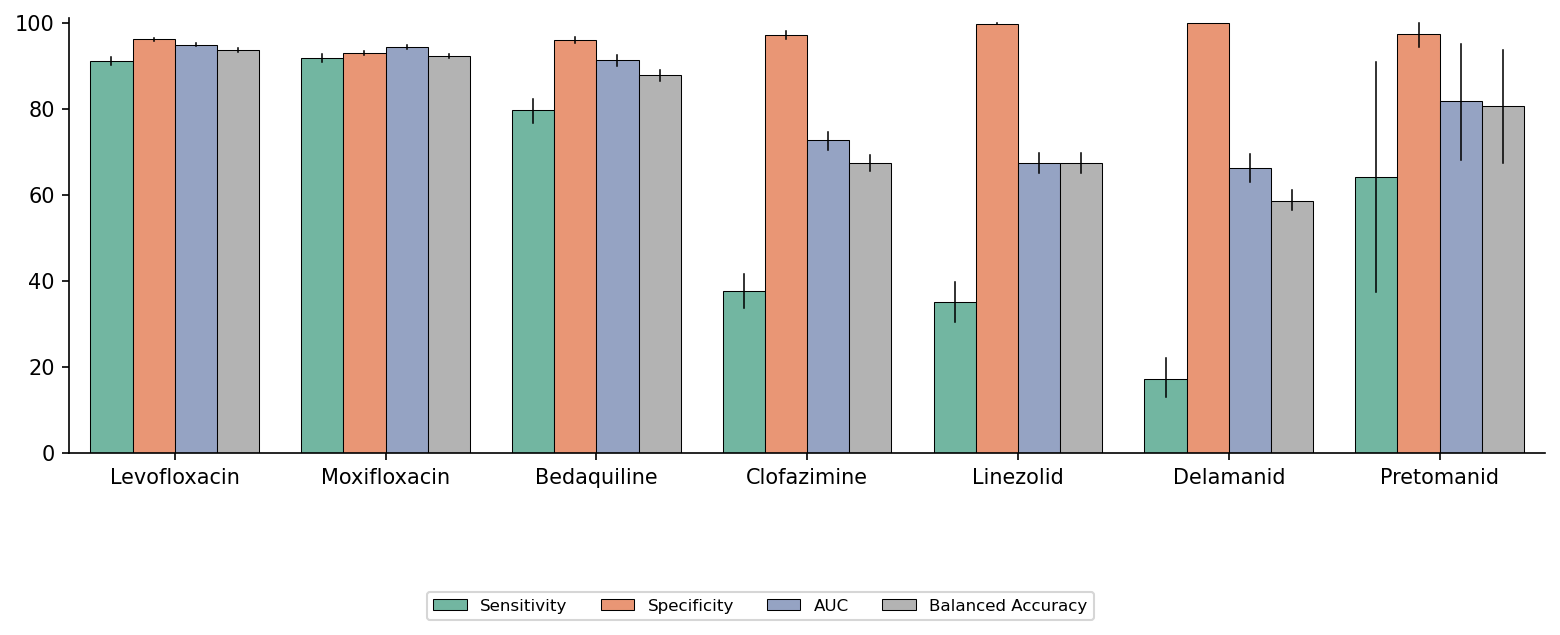

In [48]:
paths_lst = ['tiers=1+2/phenos=ALL']

tier1_ALL_results = plot_single_model_all_drugs(paths_lst, 
                                                hue_variable="variable",
                                                variable_lst=["Sensitivity", "Specificity", "AUC", "Balanced Accuracy"], 
                                                x_order=["Levofloxacin", "Moxifloxacin", "Bedaquiline", "Clofazimine", "Linezolid", "Delamanid", "Pretomanid"],
                                                sigfig=0,
                                                bootstrap=True, errorbar=("pi", 95), include_het=False, palette=sns.color_palette("Set2").as_hex()[:3] + [sns.color_palette("Set2").as_hex()[-1]], 
                                                saveName="results/TBScience/binary_metrics_ALL_no_labels.png"
                                               )

In [42]:
drug = "Moxifloxacin"
test = pd.read_csv(f"/n/data1/hms/dbmi/farhat/Sanjana/who-mutation-catalogue/{drug}/BINARY/tiers=1/phenos=ALL/model_stats_CV_bootstrap.csv")

In [43]:
for col in test.columns:
    
    if col in ["AUC", "Balanced_Acc"]:
        print(col, st.normaltest(test.query("CV > 0")[col]))

AUC NormaltestResult(statistic=15.417061163545391, pvalue=0.00044898073312713525)
Balanced_Acc NormaltestResult(statistic=14.399169779511409, pvalue=0.0007468957881274159)


(array([ 1.,  0.,  0.,  4., 10., 19., 32., 24.,  7.,  4.]),
 array([0.92825031, 0.92998017, 0.93171003, 0.93343989, 0.93516975,
        0.93689961, 0.93862948, 0.94035934, 0.9420892 , 0.94381906,
        0.94554892]),
 <BarContainer object of 10 artists>)

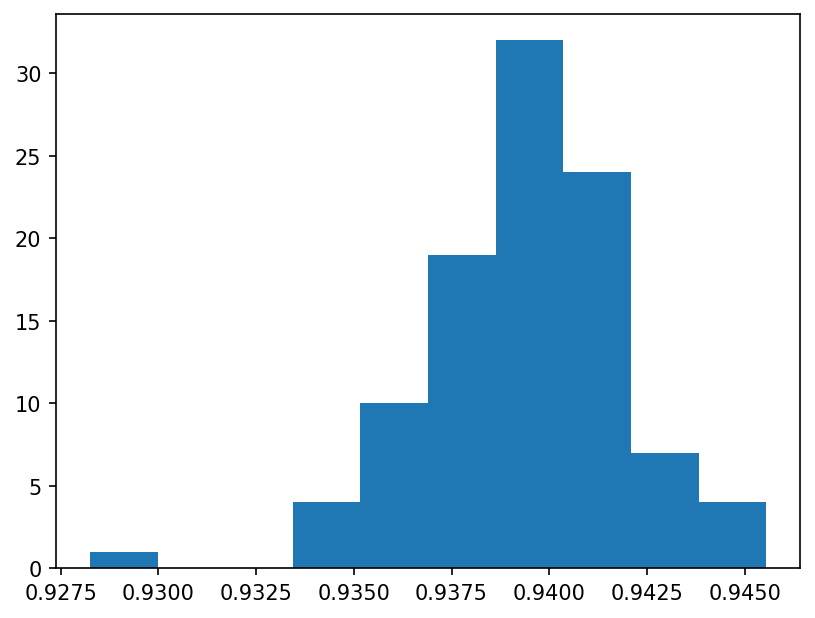

In [45]:
plt.hist(test["AUC"])

PTM: No Tier 2 genes
DLM: No significant WHO?
BDQ/MXF/LEV/CFZ: AUC+
BDQ/CFZ: Spec+
MXF/LEV: Sens+ and Spec-
BDQ: Sens-
LZD: No significant Tier 2 mutations

In [ ]:
#sns.histplot(data=LEV_results.query("variable=='Specificity' & Model.str.contains('ALL')"), x="value", hue="Model")